****
This program extracts ".dat" data (or similar) from **Quantum Design PPMS outputs**.
It has been conceived for sets of measurements whose file names follow the same document syntax. 

**example**: f'SMR-{T}K_{H}T_RotBeta_HB_transversal_Ch3-AP096_Ch2-AP096trans_Ch1-AP098_{I}µA.dat'

where T, H and I would be temperature, field and intensity values, respectively.

****

At the end of the document, versions with just "file" input.

****

The code must be present in the same directory as the .dat files, otherwise the next lines of code should be added after importing the module **os**.

In [1]:
# directory = ____ # fill with directory
# os.chdir(directory)

****
Images can be directly copied from the outputs, but if you want to save them, you can use the following lines:

In [2]:
# filename = _____ # fill with file names
# plt.savefig(filename.png', dpi = 500, bbox_inches = 'tight')

****
The relevant modules should be imported, and some parameters need to be defined:

In [3]:
import numpy as np  # arithmetic operations
import pandas as pd  # for general data operations
import matplotlib.pyplot as plt  # representation main library
import seaborn as sns  # representation extra library
import os  # operating system
import math  # math module
from scipy.optimize import curve_fit  # for the fit of curves

# to plot directly on the Jupyter notebook, highly recommended:
%matplotlib inline

In [4]:
textlines = 30 # numbers of lines that come before the real data. Header should not be considered

c_angle = 'Sample Position (degrees)' # angle column
c_r1x = 'Bridge 1 Resistivity (Ohm)'
c_r2x = 'Bridge 2 Resistivity (Ohm)'
c_r3x = 'Bridge 3 Resistivity (Ohm)'

Columns = (c_r1x, c_r2x, c_r3x) # tuple that will store the resistivity column names

angle_offset = 76 # difference between instrument's angle and real angle

****
The following function gives back a dataframe from a input of temperature, field and intensity values.

The dataframe contains the columns 'angle', 'Bridge 1 Resistivity (Ohm)', 'Bridge 2 Resistivity (Ohm)' and 'Bridge 3 Resistivity (Ohm)' 

In [5]:
def rotator_read(T, H, I):  # for 098
    '''
    Reads a given file, using a common syntax. Returns dataframe with the desired columns.
    '''

    # All the file names should follow the same syntax, otherwise a file input should be given
    file = f'SMR-{T}K_{H}T_RotBeta_HB_transversal_Ch3-AP096_Ch2-AP096trans_Ch1-AP098_{I}µA.dat'
    
    # QD's software adds 00001 or 00002 if the file is already present. The following lines check whether 
    # a "newer" version of the file exists and if it is not empty
    if not os.path.isfile(file) or os.path.getsize(file) < 1e4:
        file = file[:-4] + '_00002.dat'
    if not os.path.isfile(file) or os.path.getsize(file) < 1e4:
        file = file[:-10] + '_00001.dat'
        
    df = pd.read_csv(file, skiprows=textlines) # loads the desired data
    
    df[c_angle] = df[c_angle].apply(lambda x: x - angle_offset) # angle correction
    
    '''Sometines resistivity data is headed with "Bridge n Resistivity (Ohm)" or "___ (Ohm-m)"
    This difference has to be addressed'''
    
    for column in Columns:
        if column not in df.columns:
            df.rename(columns={column[:-1] + '-m)' : column}, inplace=True) 
        
    return df[[c_angle, c_r1x, c_r2x, c_r3x]] # returns data - desired columns


****
Showcase: 100 K, 9 T, 1000 µA. And representation (for channel 3)

In [6]:
df_show = rotator_read(100, 9, 1000)
df_show.head()

,Sample Position (degrees),Bridge 1 Resistivity (Ohm),Bridge 2 Resistivity (Ohm),Bridge 3 Resistivity (Ohm)
0,-83.994886,43.547604,NaN,73.877174
1,-78.994887,43.549911,NaN,73.875969
2,-73.994888,43.549152,NaN,73.874657
3,-68.994889,43.545059,NaN,73.873146
4,-63.994889,43.546253,NaN,73.870682


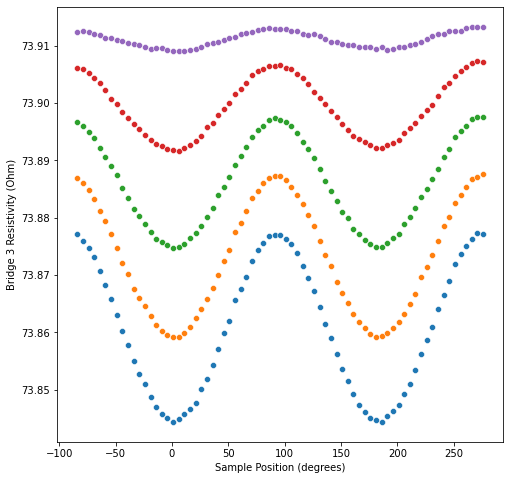

In [7]:
T_list = (100,) # list of temperatures (K)
I_list = (1000,) # list of currents (µA)
H_list = (9, 7, 5, 3, 1) # list of fields (T)

plt.figure(figsize=(8,8)) # we create a figure

for T in T_list: # scan over T values
    for H in H_list: # scan over H values
        for I in I_list: # scan over I values
            df = rotator_read(T, H, I) # stores in df variable
            sns.scatterplot(x=c_angle, y=c_r3x, data=df)

****
We define the function to fit all the curves:

In [8]:
def fit_function(x,a,b,c,d): 
    '''Function to fit the curves'''
    return [a + math.cos((x[j] + d)*math.pi/180)**2*b + (c*j) for j in range(len(x))]
    
    # x: angle in degrees
    # a: offset, R_0
    # b: cos^2 term
    # c: linear term that takes into account any thermic effect (not exact T)
    # d: offset in the angle value

In [9]:
fit_columns = ('fit_1', 'fit_2', 'fit_3') # name of columns where fits will be stored

****
The following function has the same utility than "rotator_read" but also normalises and fits the data.

In [10]:
def rotator_fit(T, H, I): 
    '''
    Same function as rotator_read, but it fits and normalises the data. 
    Fitted relative values (R-R_0)/R_0 are stored in columns "fit_1", "fit_2", "fit_3"
    '''

    # All the file names should follow the same syntax, otherwise a file input should be given
    file = f'SMR-{T}K_{H}T_RotBeta_HB_transversal_Ch3-AP096_Ch2-AP096trans_Ch1-AP098_{I}µA.dat'
    
    # QD's software adds 00001 or 00002 if the file is already present. The following lines check whether 
    # a "newer" version of the file exists and if it is not empty
    if not os.path.isfile(file) or os.path.getsize(file) < 1e4:
        file = file[:-4] + '_00002.dat'
    if not os.path.isfile(file) or os.path.getsize(file) < 1e4:
        file = file[:-10] + '_00001.dat'
        
    df = pd.read_csv(file, skiprows=textlines) # loads the desired data
    
    df[c_angle] = df[c_angle].apply(lambda x: x - angle_offset) # angle correction
    
    '''Sometines resistivity data is headed with "Bridge n Resistivity (Ohm)" or "___ (Ohm-m)"
    This difference has to be addressed.
    For the normalisation, a backup plan to prevent None values to raise an error has been considered'''
    
    for column in Columns:
        
        if column not in df.columns:
            df.rename(columns={column[:-1] + '-m)' : column}, inplace=True) 
            
        if len(df[column].dropna()) != 0:
            df[column] = (df[column] - min(df[column]))/min(df[column])
            
            # Fit function:
            par, cov = curve_fit(f=fit_function, 
                                 xdata = df[c_angle],
                                 ydata = df[column], 
                                 bounds=(-np.inf, np.inf),  
                                 maxfev = 10000)
            
            # Stores fit result:
            df[fit_columns[Columns.index(column)]] = fit_function(df[c_angle], par[0], par[1], par[2], par[3])
            
        else:
            df[fit_columns[Columns.index(column)]] = df[column] # The fit_column is also filled with None
            
    return df[[c_angle, c_r1x, c_r2x, c_r3x, 'fit_1', 'fit_2', 'fit_3']] # returns data - desired columns

    

****
Showcase: 100 K, 9 T, 1000 µA. And representation (for channel 3)

In [11]:
df_show = rotator_fit(100, 9, 1000)
df_show.head()

,Sample Position (degrees),Bridge 1 Resistivity (Ohm),Bridge 2 Resistivity (Ohm),Bridge 3 Resistivity (Ohm),fit_1,fit_2,fit_3
0,-83.994886,0.000541,NaN,0.000445,0.000580,NaN,0.000433
1,-78.994887,0.000594,NaN,0.000428,0.000570,NaN,0.000426
2,-73.994888,0.000576,NaN,0.000411,0.000552,NaN,0.000412
3,-68.994889,0.000482,NaN,0.000390,0.000526,NaN,0.000392
4,-63.994889,0.000510,NaN,0.000357,0.000494,NaN,0.000367


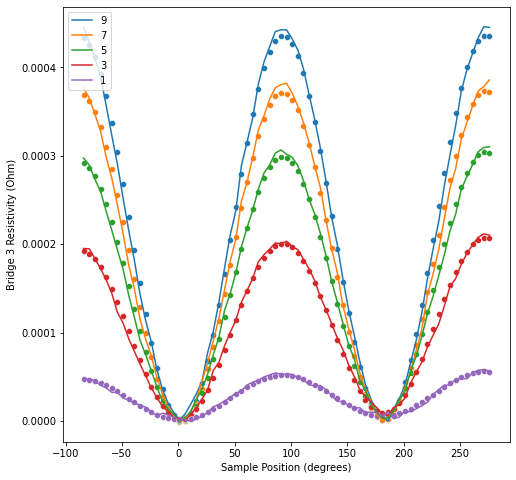

In [12]:
T_list = (100,) # list of temperatures (K)
I_list = (1000,) # list of currents (µA)
H_list = (9, 7, 5, 3, 1) # list of fields (T)

plt.figure(figsize=(8,8)) # we create a figure

for T in T_list: # scan over T values
    for H in H_list: # scan over H values
        for I in I_list: # scan over I values
            df = rotator_fit(T, H, I) # stores in df variable
            
            sns.lineplot(x=c_angle, y=c_r3x, data=df, label=H)
            sns.scatterplot(x=c_angle, y='fit_3', data=df)

****
Plots can be improved in a stylish way:

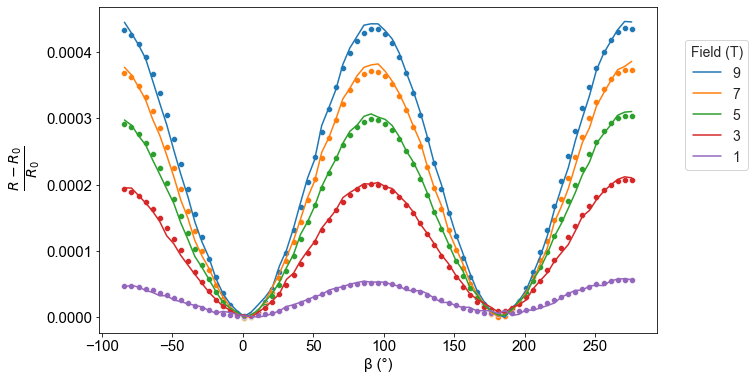

In [13]:
T_list = (100,) # list of temperatures (K)
I_list = (1000,) # list of currents (µA)
H_list = (9, 7, 5, 3, 1) # list of fields (T)

plt.figure(figsize=(10, 6)) # we create a figure

plt.xlabel('β (°)', fontsize=15)
plt.ylabel(r' $\frac{R - R_{0}}{R_{0}}$', fontsize=20)

sns.set_style("ticks")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for T in T_list: # scan over T values
    for H in H_list: # scan over H values
        for I in I_list: # scan over I values
            df = rotator_fit(T, H, I) # stores in df variable
            
            sns.lineplot(x=c_angle, y=c_r3x, data=df, label=H)
            sns.scatterplot(x=c_angle, y='fit_3', data=df)
            
legend = plt.legend(title='Field (T)', fontsize=14, loc=(1.05, 0.5))
legend.get_title().set_fontsize('14')

****
In order to get the amplitudes as a function of T and H:

In [14]:
data_table = pd.DataFrame(columns=('T', 'H', 'I', 'amp_1', 'amp_2', 'amp_3')) # where the values will be stored

T_list = (50, 60, 80, 100, 120, 140, 160, 180, 200, 220, 260, 280, 300) # list of temperatures (K)
I_list = (1000,) # list of currents (µA)
H_list = (9, 7, 5, 3, 1) # list of fields (T)

for T in T_list: # scan over T values
    for H in H_list: # scan over H values
        for I in I_list: # scan over I values
            df = rotator_fit(T, H, I) # stores in df variable
            
            data_table.loc[len(data_table)] = [T, H, I, max(df['fit_1']), max(df['fit_2']), max(df['fit_3'])]

****
Values check and representation for channel 3:

In [15]:
data_table.head()

,T,H,I,amp_1,amp_2,amp_3
0,50.0,9.0,1000.0,0.000705,NaN,0.000438
1,50.0,7.0,1000.0,0.000603,NaN,0.000392
2,50.0,5.0,1000.0,0.000517,NaN,0.000333
3,50.0,3.0,1000.0,0.000396,NaN,0.000243
4,50.0,1.0,1000.0,0.000165,NaN,0.000107


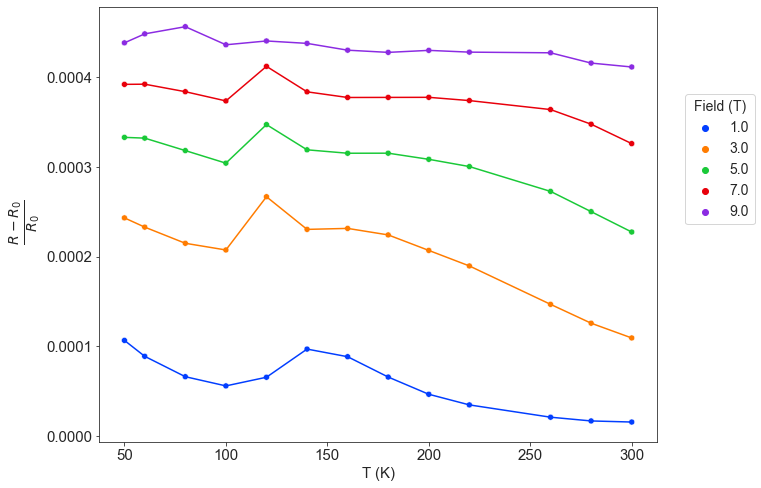

In [16]:
plt.figure(figsize=(10, 8)) # we create a figure

plt.xlabel('T (K)', fontsize=15)
plt.ylabel(r' $\frac{R - R_{0}}{R_{0}}$', fontsize=20)

sns.set_style("ticks")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

sns.scatterplot(x='T', y='amp_3', data=data_table, hue='H', palette='bright')
sns.lineplot(x='T', y='amp_3', data=data_table, hue='H', palette='bright', legend=None)
            
legend = plt.legend(title='Field (T)', fontsize=14, loc=(1.05, 0.5))
legend.get_title().set_fontsize('14')

***
The following two functions are conceived for people just wanted to input a file name, instead of a H, I, T set and a given syntax.

In [17]:
def rotator_readfile(file):  
    '''
    Reads a given file, the file name must be explicited.
    '''
    df = pd.read_csv(file, skiprows=textlines) # loads the desired data
    
    df[c_angle] = df[c_angle].apply(lambda x: x - angle_offset) # angle correction
    
    '''Sometines resistivity data is headed with "Bridge n Resistivity (Ohm)" or "___ (Ohm-m)"
    This difference has to be addressed'''
    
    for column in Columns:
        if column not in df.columns:
            df.rename(columns={column[:-1] + '-m)' : column}, inplace=True) 
        
    return df[[c_angle, c_r1x, c_r2x, c_r3x]] # returns data - desired columns

In [18]:
def rotator_fitfile(file):  # for 098
    '''
    Same function as rotator_read, but it fits and normalises the data. The file name must be explicited.
    Fitted relative values (R-R_0)/R_0 are stored in columns "fit_1", "fit_2", "fit_3"
    '''
     
    df = pd.read_csv(file, skiprows=textlines) # loads the desired data
    
    df[c_angle] = df[c_angle].apply(lambda x: x - angle_offset) # angle correction
    
    '''Sometines resistivity data is headed with "Bridge n Resistivity (Ohm)" or "___ (Ohm-m)"
    This difference has to be addressed.
    For the normalisation, a backup plan to prevent None values to raise an error has been considered'''
    
    for column in Columns:
        
        if column not in df.columns:
            df.rename(columns={column[:-1] + '-m)' : column}, inplace=True) 
            
        if len(df[column].dropna()) != 0:
            df[column] = (df[column] - min(df[column]))/min(df[column])
            
            # Fit function:
            par, cov = curve_fit(f=fit_function, 
                                 xdata = df[c_angle],
                                 ydata = df[column], 
                                 bounds=(-np.inf, np.inf),  
                                 maxfev = 10000)
            
            # Stores fit result:
            df[fit_columns[Columns.index(column)]] = fit_function(df[c_angle], par[0], par[1], par[2], par[3])
            
        else:
            df[fit_columns[Columns.index(column)]] = df[column] # The fit_column is also filled with None
            
    return df[[c_angle, c_r1x, c_r2x, c_r3x, 'fit_1', 'fit_2', 'fit_3']] # returns data - desired columns
